In [127]:

import os
import utils
import dotenv
import umap
import pandas as pd
import scipy.stats as stats
import numpy as np
import dataextraction as db
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans, Birch
import hdbscan
from statsmodels.multivariate.manova import MANOVA

## Loading and Preprocessing Data
Before moving onto the clustering, we need to load the data and preprocess it. The data is loaded from the file `finalrefined.csv` by importing OS for obtaining root path of the project and referencing `finalrefined.csv` in the data folder. 

In [97]:
dotenv.load_dotenv()

True

In [98]:
df = pd.read_csv(f'{os.getenv("ROOT_DIR")}\\data\\finalrefined.csv')
df

,subject_id,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,aniongap_mean,...,discharge_location_OTHER FACILITY,discharge_location_REHAB/DISTINCT PART HOSP,discharge_location_SHORT TERM HOSPITAL,discharge_location_SNF,discharge_location_SNF-MEDICAID ONLY CERTIF,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay
0,3,111.785714,102.960000,55.720000,75.692812,17.361111,37.002881,97.870968,232.416667,19.000000,...,False,False,False,True,False,False,False,True,False,False
1,9,92.500000,159.375000,79.525000,98.850000,14.369565,37.049383,97.650000,161.285714,13.000000,...,False,False,False,False,False,False,True,False,False,False
2,21,71.385714,101.817016,44.110723,65.891024,16.838690,36.796465,98.057598,160.000000,21.000000,...,False,False,False,False,False,False,False,True,False,False
3,25,72.906250,100.000000,46.583333,63.324330,16.031250,36.333333,97.096774,164.766667,13.000000,...,False,False,False,False,False,False,False,False,True,False
4,31,51.230769,114.153846,59.923077,79.923077,12.066667,36.958333,98.714286,108.142857,9.500000,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10188,99913,93.676471,117.111111,51.166667,69.194444,18.200000,36.936000,98.562500,129.434783,11.500000,...,False,False,False,False,False,False,False,True,False,False
10189,99922,86.185185,111.068966,55.206897,69.206897,15.678571,36.555128,97.592593,124.684211,11.000000,...,False,False,False,False,False,False,False,True,False,False
10190,99923,95.006944,106.881558,59.216216,72.278219,15.500000,36.516204,97.685484,130.333333,15.000000,...,False,False,False,False,False,False,False,False,True,False
10191,99944,74.461538,130.730769,53.923077,72.769231,22.600000,36.111111,94.423077,138.000000,17.000000,...,False,False,False,True,False,False,False,True,False,False


Mapping mortality rates with the function `aggregate_score_to_mortality()` from the utils module for mapping LODS scores of the patients with the related logit functions, these mortality rates will be further used for mapping patients to ICU levels 

In [99]:

df_subject_mr = utils.aggregate_score_to_mortality()
df_subject_mr

Connected to the PostgreSQL database
PostgreSQL version: PostgreSQL 14.0, compiled by Visual C++ build 1914, 64-bit


,subject_id,mr_lods
0,25225,0.104107
1,15574,0.048017
2,52619,0.048017
3,85940,0.048017
4,12411,0.288948
...,...,...
61046,3793,0.149936
61047,11099,0.288948
61048,93831,0.071114
61049,50334,0.104107


Mergeing mortality rates with the base dataset for matching with the aggregateunqiue patient records, ad and one-hot encoded features and further avoiding duplicate patient records since the df_subject_mr includes duplicated subject records for mapped mortality rates

In [100]:
df = df.merge(df_subject_mr.drop_duplicates(subset='subject_id'), on='subject_id', how='left')
df

,subject_id,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,aniongap_mean,...,discharge_location_REHAB/DISTINCT PART HOSP,discharge_location_SHORT TERM HOSPITAL,discharge_location_SNF,discharge_location_SNF-MEDICAID ONLY CERTIF,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay,mr_lods
0,3,111.785714,102.960000,55.720000,75.692812,17.361111,37.002881,97.870968,232.416667,19.000000,...,False,False,True,False,False,False,True,False,False,0.683240
1,9,92.500000,159.375000,79.525000,98.850000,14.369565,37.049383,97.650000,161.285714,13.000000,...,False,False,False,False,False,True,False,False,False,0.149936
2,21,71.385714,101.817016,44.110723,65.891024,16.838690,36.796465,98.057598,160.000000,21.000000,...,False,False,False,False,False,False,True,False,False,0.483531
3,25,72.906250,100.000000,46.583333,63.324330,16.031250,36.333333,97.096774,164.766667,13.000000,...,False,False,False,False,False,False,False,True,False,0.288948
4,31,51.230769,114.153846,59.923077,79.923077,12.066667,36.958333,98.714286,108.142857,9.500000,...,False,False,False,False,False,False,True,False,False,0.104107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10188,99913,93.676471,117.111111,51.166667,69.194444,18.200000,36.936000,98.562500,129.434783,11.500000,...,False,False,False,False,False,False,True,False,False,0.149936
10189,99922,86.185185,111.068966,55.206897,69.206897,15.678571,36.555128,97.592593,124.684211,11.000000,...,False,False,False,False,False,False,True,False,False,0.149936
10190,99923,95.006944,106.881558,59.216216,72.278219,15.500000,36.516204,97.685484,130.333333,15.000000,...,False,False,False,False,False,False,False,True,False,0.483531
10191,99944,74.461538,130.730769,53.923077,72.769231,22.600000,36.111111,94.423077,138.000000,17.000000,...,False,False,True,False,False,False,True,False,False,0.104107


Finally applying `map_mortality_rate_to_icu_level` for obtaining related ICU levels to the patients, we simply divided mortality rates to number of ICU levels (3 in this case) from 0.0 (mild) to 1 (critical)

In [101]:
df['icu_level'] = df['mr_lods'].apply(utils.map_mortality_rate_to_icu_level)
df['icu_level']

0        Level 3
1        Level 1
2        Level 2
3        Level 1
4        Level 1
          ...   
10188    Level 1
10189    Level 1
10190    Level 2
10191    Level 1
10192    Level 1
Name: icu_level, Length: 10193, dtype: object

In [102]:
df["icu_level"].describe()

count       10193
unique          3
top       Level 1
freq         7807
Name: icu_level, dtype: object

Removing unecessary columns such as ID's mortality rates since we are only interested in ICU levels and not removing mortality rates could lead to data leakage.

In [103]:

columns_to_remove = ["subject_id", "hadm_id", "icustay_id", "mr_lods"]
df = df.drop(columns_to_remove, axis=1)

Lable encoding the ICU levels for further since some of the clustering models don't accept string values 

In [104]:
label_encoder = LabelEncoder()
df["icu_level"] = label_encoder.fit_transform(df["icu_level"])
df["icu_level"]

0        2
1        0
2        1
3        0
4        0
        ..
10188    0
10189    0
10190    1
10191    0
10192    0
Name: icu_level, Length: 10193, dtype: int32

## Clustering and Dimensionality Reduction
For further operation on the dataset we first reduce the dimension of the data. Data has a high number of features (high-dimensional), dimensionality reduction techniques like Principal Component Analysis (PCA) or t-distributed Stochastic Neighbor Embedding (t-SNE) can be used to reduce the dimensionality. High-dimensional data can suffer from the "curse of dimensionality," leading to increased computational complexity and decreased clustering performance. Reducing dimensionality can help address these issues and improve clustering results. By reducing the dimensionality, you might retain the most important information while discarding noise or irrelevant features, which can lead to more meaningful clustering results.

In [105]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [106]:
pca = PCA(n_components=20)
pca_result = pca.fit_transform(scaled_data)

In [107]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

In [108]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_reducer.fit_transform(pca_result)

Visualizing the reduced dimensions of the dataset

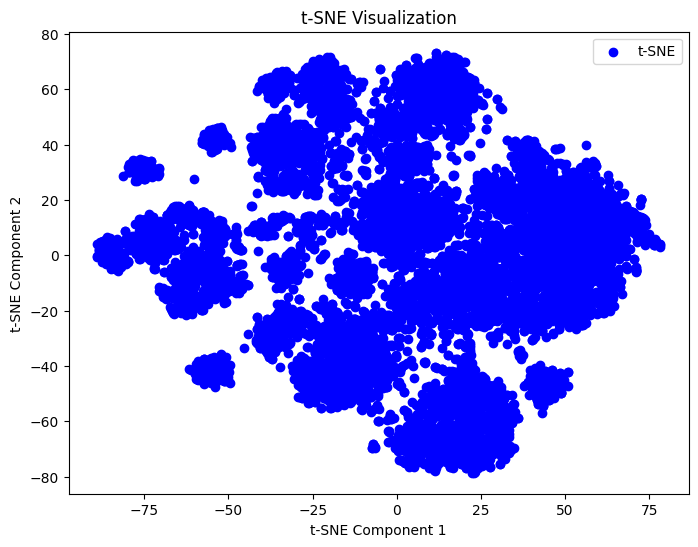

In [109]:
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='b', marker='o', label='t-SNE')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

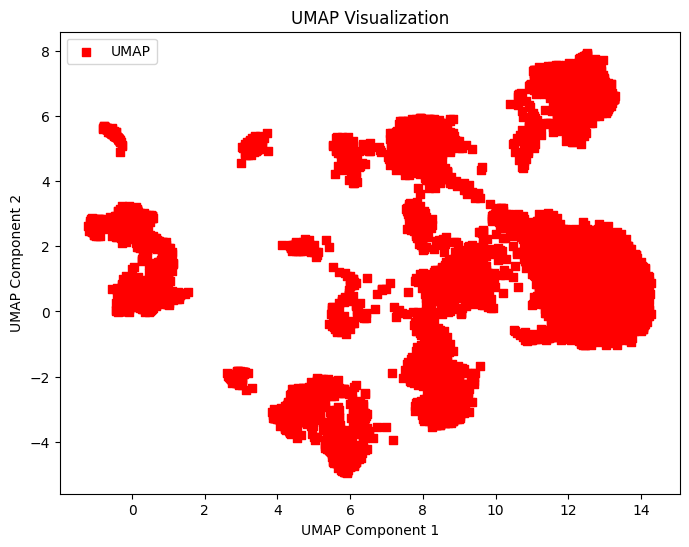

In [110]:
plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c='r', marker='s', label='UMAP')
plt.title('UMAP Visualization')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

Running clustering algorithms on the dimensionality reduced data 

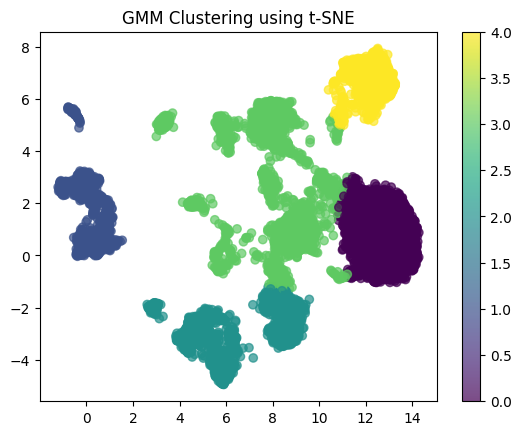

In [111]:
n_clusters = 5

gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(umap_result)

df['GMM_Cluster_UMAP'] = gmm_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=gmm_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('GMM Clustering using t-SNE')
plt.show()

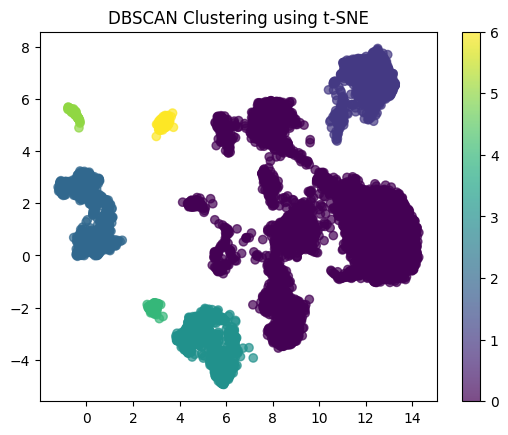

In [112]:
eps = 0.8
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(umap_result)

df['DBSCAN_Cluster_UMAP'] = dbscan_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('DBSCAN Clustering using t-SNE')
plt.show()

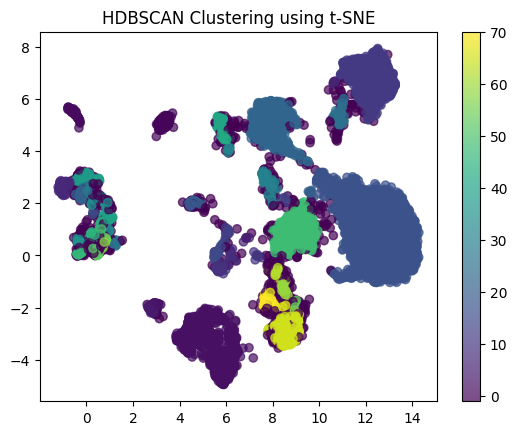

In [113]:
min_cluster_size = 5

hdb = hdbscan.HDBSCAN(min_samples=min_cluster_size)
hdb_labels = hdb.fit_predict(umap_result)

df['HDBSCAN_Cluster_UMAP'] = hdb_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=hdb_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('HDBSCAN Clustering using t-SNE')
plt.show()

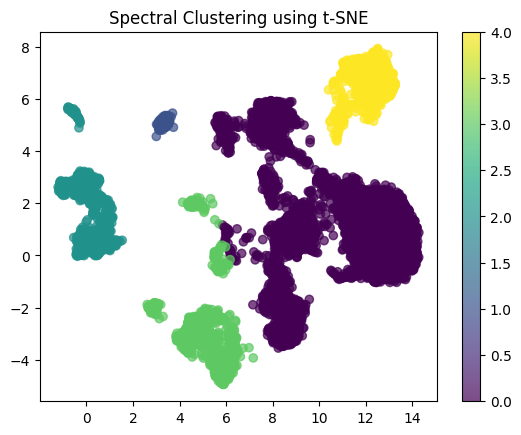

In [114]:
n_clusters = 5

spectral_clustering = SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack', random_state=42)
spectral_labels = spectral_clustering.fit_predict(umap_result)

df['Spectral_Cluster_UMAP'] = spectral_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=spectral_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('Spectral Clustering using t-SNE')
plt.show()

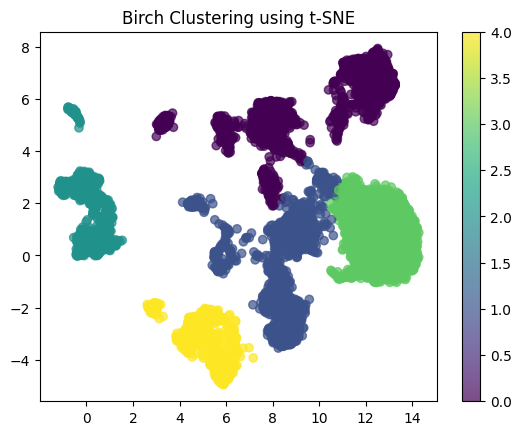

In [115]:
n_clusters = 5

birch = Birch(n_clusters=n_clusters)
birch_labels = birch.fit_predict(umap_result)

df['Birch_Cluster_UMAP'] = birch_labels

# Plotting the Birch clusters in 2D (assuming tsne_result, you can use umap_result as well)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=birch_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('Birch Clustering using t-SNE')
plt.show()

d:\workspace\github\icu-flow-prediction\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


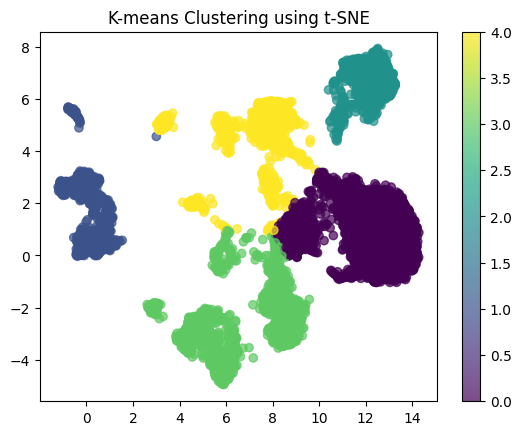

In [116]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(umap_result)

df['KMeans_Cluster_UMAP'] = kmeans_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('K-means Clustering using t-SNE')
plt.show()

## Cluster Analysis
Further we analyzed each clusters characteristics, how ICU level is scattered around on the clusters, how other features are scatter and affected the clustering and so on

In [117]:
# average_mortality = df.groupby('KMeans_Cluster')['mr_lods'].mean()

# print("Average Mortality Rate for Each Cluster:")
# print(average_mortality)

In [118]:
# median_mortality = df.groupby('Birch_Cluster')['mr_lods'].median()

# print("Median Mortality Rate for Each Cluster:")
# print(median_mortality)

In [119]:
# num_clusters = len(average_mortality)
# colors = ['grey'] * num_clusters

# colors[2] = 'blue'
# colors[4] = 'red'

# plt.scatter(umap_result[:, 0], umap_result[:, 1], c=[colors[label] for label in df["KMeans_Cluster"]], alpha=0.7)

# plt.colorbar()
# plt.title('KMeans Clustering using t-SNE')
# plt.show()

In [120]:
# icu_level_colors = {
#     0: 'lightgrey',
#     1: 'blue',
#     2: 'red'
# }

# colors_by_icu_level = [icu_level_colors[level] for level in df['icu_level']]

# plt.scatter(umap_result[:, 0], umap_result[:, 1], c=colors_by_icu_level, marker='.', alpha=0.7)

# plt.colorbar()
# plt.title('ICU Level Colored Clustering using t-SNE')
# plt.show()

In [121]:
columns_to_drop = ["KMeans_Cluster_UMAP", 
                  "Birch_Cluster_UMAP", 
                  "Spectral_Cluster_UMAP", 
                  "DBSCAN_Cluster_UMAP", 
                  "HDBSCAN_Cluster_UMAP",
                  "GMM_Cluster_UMAP"]
cluster_labels = df['GMM_Cluster_UMAP']
features = df.drop(columns_to_drop, axis=1)

In [140]:
bool_columns = []
for key, val in features.dtypes.to_dict().items():
    if(val == "bool"):
        bool_columns.append(key)
bool_columns

[]

In [139]:
features = features[bool_columns].astype(int)
features

,first_hosp_stay,first_icu_stay,marital_status_DIVORCED,marital_status_LIFE PARTNER,marital_status_MARRIED,marital_status_SEPARATED,marital_status_SINGLE,marital_status_UNKNOWN (DEFAULT),marital_status_WIDOWED,ethnicity_grouped_asian,...,discharge_location_OTHER FACILITY,discharge_location_REHAB/DISTINCT PART HOSP,discharge_location_SHORT TERM HOSPITAL,discharge_location_SNF,discharge_location_SNF-MEDICAID ONLY CERTIF,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay
0,1,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10188,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10189,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10190,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10191,1,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


In [134]:
cluster_labels = pd.Categorical(cluster_labels)
cluster_labels

[0, 3, 3, 2, 3, ..., 2, 1, 0, 2, 2]
Length: 10193
Categories (5, int64): [0, 1, 2, 3, 4]

In [135]:
manova_model = MANOVA.from_formula('features ~ C(cluster_labels)', data=df)
manova_result = manova_model.mv_test()

PatsyError: categorical data cannot be >1-dimensional

In [ ]:
print(manova_result.summary())

In [ ]:
pillai_trace_statistic = manova_result.results['Wilks\' lambda']['Stat']
print(f"Pillai's Trace statistic: {pillai_trace_statistic}")

In [ ]:
f_statistic = manova_result.results['C(cluster_labels)']['stat']['F Value']
p_value = manova_result.results['C(cluster_labels)']['stat']['Pr > F']
print(f"F-statistic: {f_statistic}, p-value: {p_value}")